In [1]:
%load_ext autoreload
%autoreload 2

In [25]:
import sys
import os
sys.path.append(os.pardir)

In [49]:
from create_hdf_dataset import create_bird_spectrogram_hdf, create_hdfs, create_bird_spectrogram_hdf_external

In [50]:
from glob import glob

In [23]:
import h5py
import numpy as np

# define path to wav files and output path for hdf files

using bird data from tchernichovski and jarvis 2021

In [135]:
path2wavs = '/home/gagan/data/tchernichovski_jarvis_2021/'

out_path = '/home/gagan/data/zudeep/bird_hdfs/'

In [182]:
birds = glob(path2wavs + 'Box*')
birdnames = [b.split('/')[-1] for b in birds]
print('.... %d birds found ....'%(len(birdnames)))

.... 230 birds found ....


In [137]:
birdnames[0]

'Box5_HP24'

# create individual bird hdfs

Tchernichovski, Jarvis 2021 birds

In [ ]:
for i in range(len(birdnames)):
    if not os.path.exists(os.path.join(out_path, birdnames[i])):
        create_bird_spectrogram_hdf_external(birdnames[i], birds[i], out_path, target_sampling_rate=16000, standardize=False, nfft=256,
                                         min_syll_dur_frames=20, energy_thresh_percent=0.1, compress_type='gzip', compression_idx=9)

..... bird Box5_HP24 number of songs = 93 .....
..... bird Box5_HP24 finished in 33.42 secs.....
..... bird Box2_Brn7 number of songs = 374 .....
..... bird Box2_Brn7 finished in 132.47 secs.....
..... bird Box3_BRN20 number of songs = 377 .....
..... bird Box3_BRN20 finished in 166.98 secs.....
..... bird Box1_Or35RU number of songs = 31 .....
..... bird Box1_Or35RU finished in 8.92 secs.....
..... bird Box1_Or375HP number of songs = 482 .....
..... bird Box1_Or375HP finished in 182.91 secs.....
..... bird Box6_DB15HP number of songs = 165 .....
..... bird Box6_DB15HP finished in 55.14 secs.....
..... bird Box2_DG107 number of songs = 292 .....
..... bird Box2_DG107 finished in 95.79 secs.....
..... bird Box8_HP39 number of songs = 85 .....
..... bird Box8_HP39 finished in 15.75 secs.....
..... bird Box8_R57HP number of songs = 170 .....
..... bird Box8_R57HP finished in 58.66 secs.....
..... bird Box5_OR10 number of songs = 434 .....


Our birdsongs

In [9]:
path2wavs = '/home/gagan/data/zudeep/wav_files/'

In [17]:
create_hdfs(path2wavs, out_path, extention='SAP_allfiles', extention2 = 'songs', 
                downsample_factor = 2, nfft = 256)


 ..... bird is b14r16_tutor ....


 ..... bird is k6r16_tutor ....


 ..... bird is b9r14 ....


 ..... bird is b13r14 ....


 ..... bird is r15y5_tutor ....

..... bird r15y5_tutor finished in 20.28 secs.....

 ..... bird is r15y2_tutor ....

..... bird r15y2_tutor finished in 19.77 secs.....

 ..... bird is g20r15_tutor ....

..... bird g20r15_tutor finished in 9.06 secs.....


# explore one birds file

 load one hdf file

In [141]:
birdfile = h5py.File(os.path.join(out_path, 'Box3_Wh283'),'r')

list some data folders for this bird

In [143]:
list(birdfile['/Box3_Wh283/'].keys())

['FD', 'UD']

list some wav files for one folder

In [151]:
list(birdfile['/Box3_Wh283/UD'].keys())[-5:]

['Wh283_43634.40690005_6_18_11_18_10.wav',
 'Wh283_43634.40702130_6_18_11_18_22.wav']

In [46]:
birdfile.close()

# plot a spectrogram

In [29]:
import matplotlib.pyplot as plt
from utils.utils import transform, rescale_spectrogram

In [175]:
S = np.array(birdfile['/Box3_Wh283/UD/Wh283_43634.40690005_6_18_11_18_10.wav'])
S.shape

(129, 2801, 2)

In [176]:
S = transform(S)

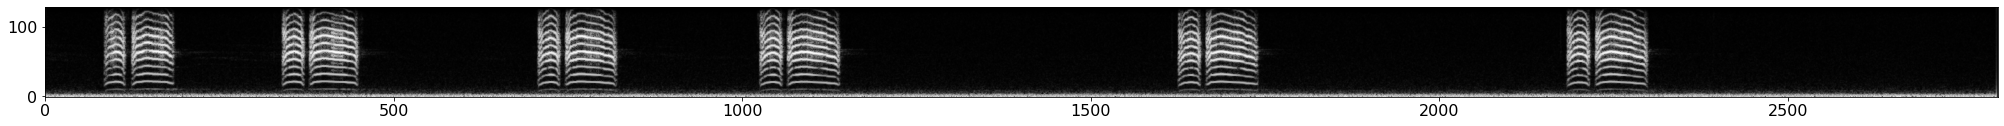

In [177]:
plt.figure(figsize = (35,12))
plt.imshow(rescale_spectrogram(S), cmap = 'gray', origin='lower')
plt.show()

In [181]:
ss = S.sum(axis=0)
thresh=np.min(ss)+ 0.2*(np.max(ss)-np.min(ss))
thresh

10.943526280010513

In [179]:
mask = truncate_silence(ss, thresh)

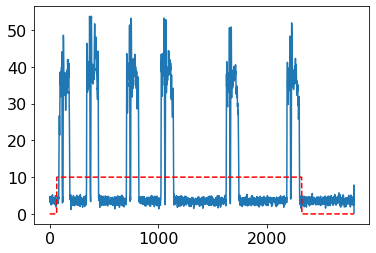

In [180]:
plt.plot(ss)
#plt.plot(mask*10, '-r')
plt.plot(mask*10,'--r')

In [88]:
import pdb

In [24]:
birdfile.close()

# make id lists

ID lists are used by the songbird_dataset class to select random spectrograms during training

In [5]:
out_path

'/media/songbird/datapartition/mdgan_training_input_with_age_HDF/'

In [7]:
id_list, age_weight_list, cnt = make_ID_list(out_path)

..... 0 of 14 birds indexed .....
..... 1 of 14 birds indexed .....
..... 2 of 14 birds indexed .....
..... 3 of 14 birds indexed .....
..... 4 of 14 birds indexed .....
..... 5 of 14 birds indexed .....
..... 6 of 14 birds indexed .....
..... 7 of 14 birds indexed .....
..... 8 of 14 birds indexed .....
..... 9 of 14 birds indexed .....
..... 10 of 14 birds indexed .....
..... 11 of 14 birds indexed .....
..... 12 of 14 birds indexed .....
..... 13 of 14 birds indexed .....


# split id lists into test and train

In [8]:
id_list_train, id_list_test = split_ids_train_test(id_list, train_test_ratio = 0.9)

# save id and age weight lists with pickle (only use pickle!)

In [11]:
import pickle

In [13]:
with open('/media/songbird/datapartition/id_list_train.pkl','wb') as f:
    pickle.dump(id_list_train, f, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('/media/songbird/datapartition/id_list_test.pkl','wb') as f:
    pickle.dump(id_list_test, f, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
age_weights_train = [ids['age_weight'] for ids in id_list_train]
age_weights_test = [ids['age_weight'] for ids in id_list_test]

In [15]:
with open('/media/songbird/datapartition/age_weights_training.pkl', 'wb') as f: 
    pickle.dump(age_weights_train, f, protocol=pickle.HIGHEST_PROTOCOL)
with open('/media/songbird/datapartition/age_weights_test.pkl', 'wb') as f: 
    pickle.dump(age_weights_test, f, protocol=pickle.HIGHEST_PROTOCOL)